# QRT ENS Data Challenge 2023 - Benchmark

This notebook details the benchmark construction for the challenge - it may also help participants to start the competition.

## Libraries

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [9]:
import seaborn as sns

## Loading data

- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated with a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.


In [5]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:

X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('Y_train.csv')
X_test = pd.read_csv('X_test.csv')

In [6]:
X_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [47]:
Y_train.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


## Exploratory Data Analysis and Pre-Processing

Let's see how big our training and test datasets are and the types of values they contain.

In [34]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (1494, 35)
X_test shape:  (654, 35)


In [15]:
X_train.dtypes.value_counts()

float64    32
int64       2
object      1
Name: count, dtype: int64

All our columns are numerical values besides the COUNTRY column.

Let's look at the distribution of the variables.

/var/folders/_t/zvd8y8fs37xghvq_vdrrsw5c0000gn/T/ipykernel_34948/3640263603.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train[col])
/var/folders/_t/zvd8y8fs37xghvq_vdrrsw5c0000gn/T/ipykernel_34948/3640263603.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train[col])
/var/folders

KeyboardInterrupt: 

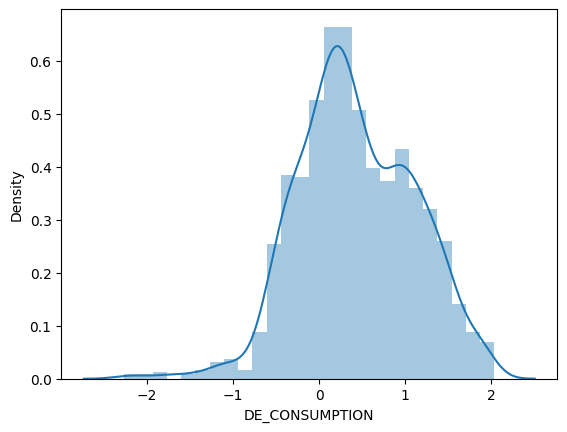

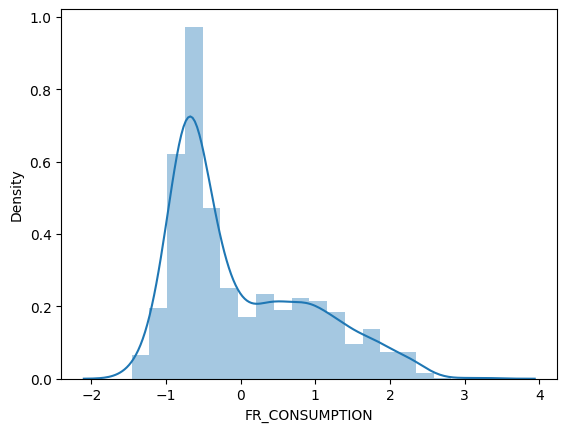

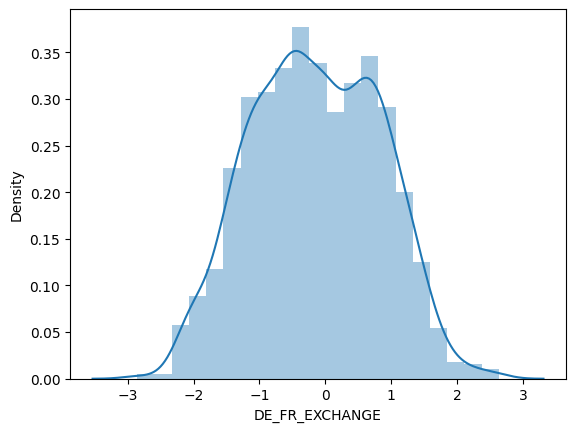

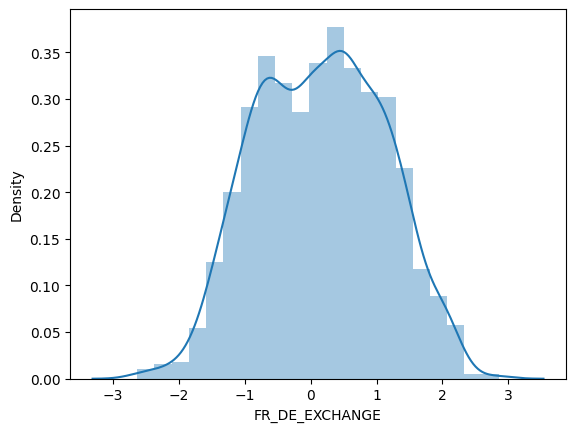

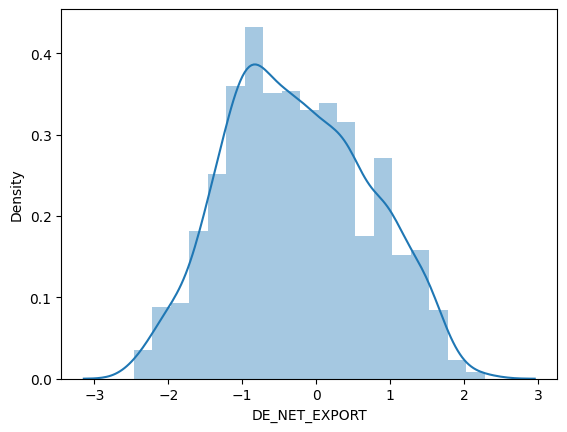

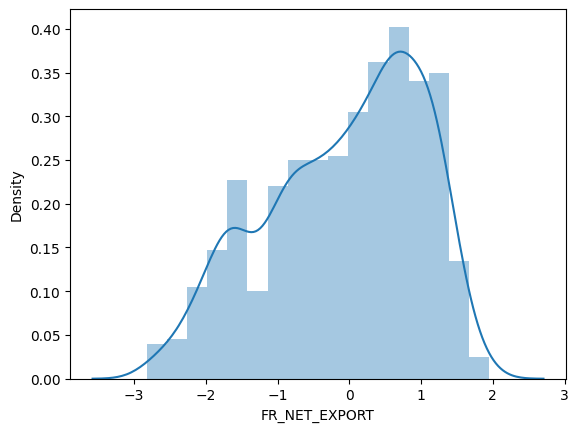

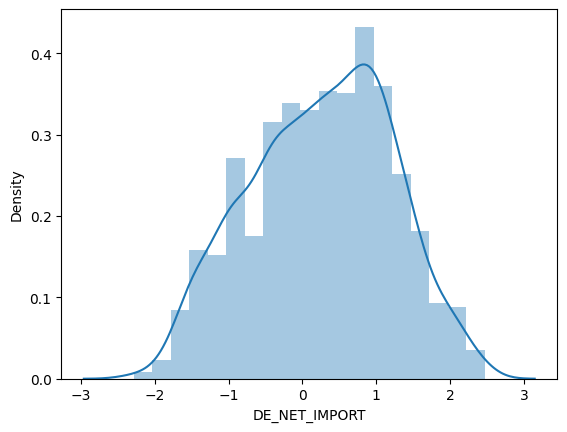

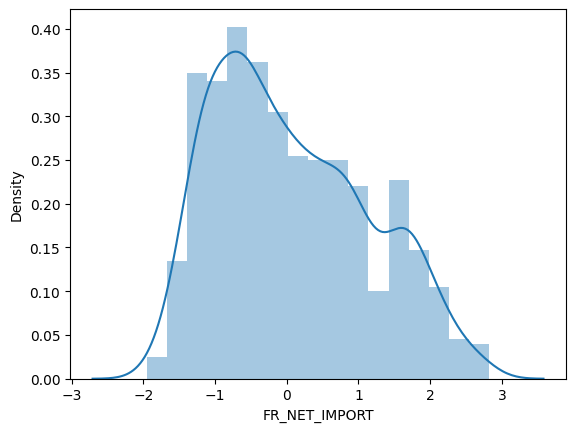

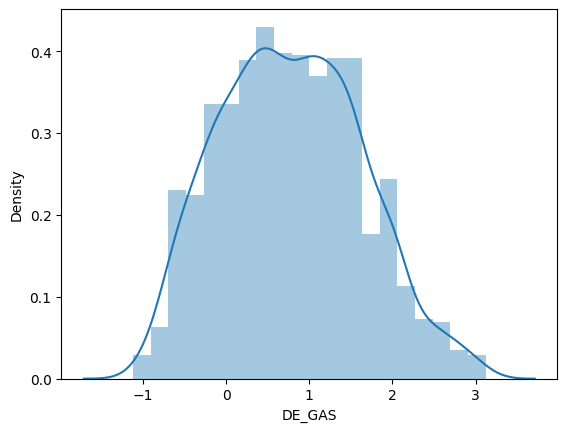

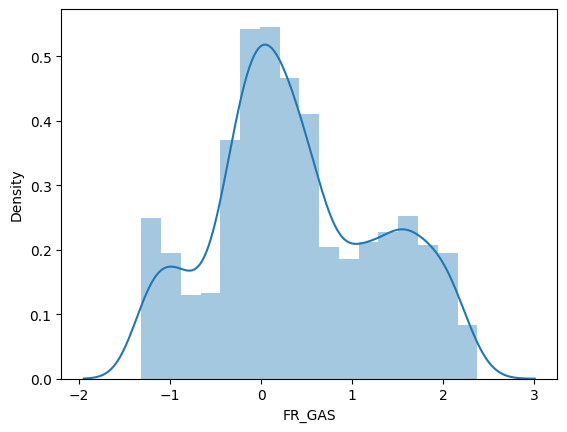

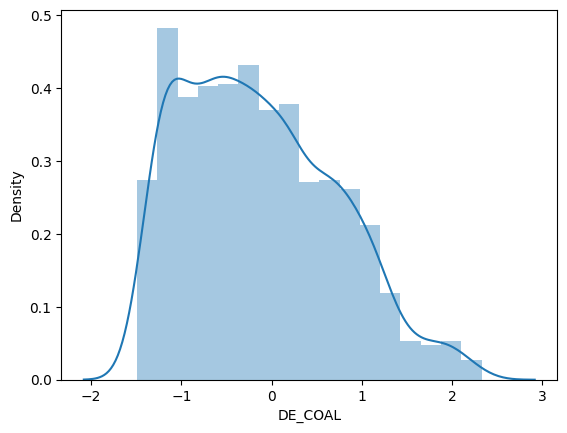

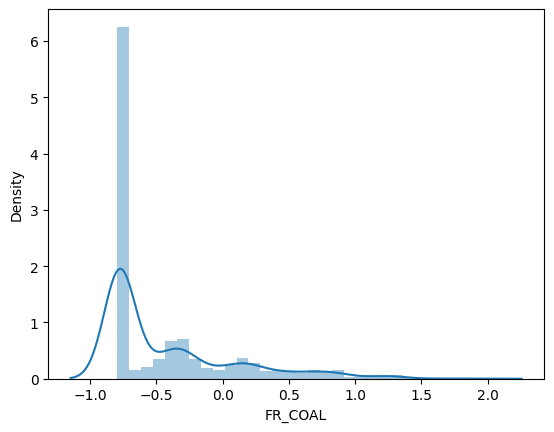

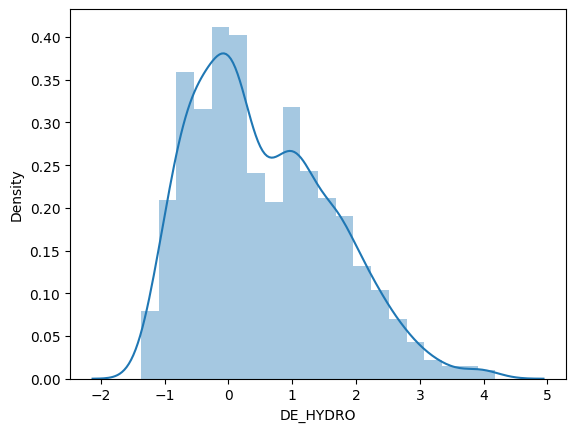

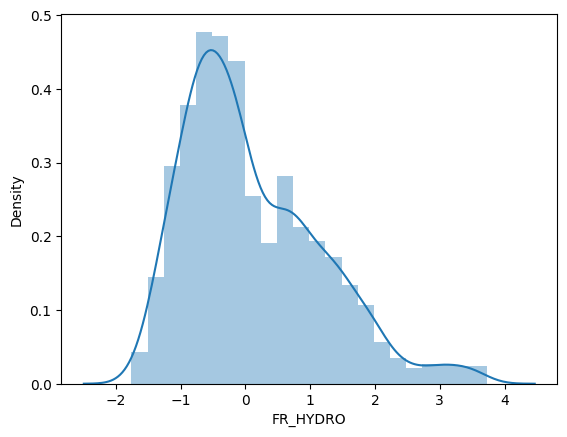

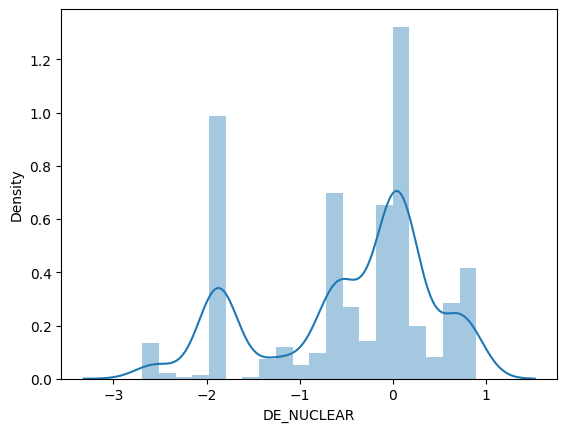

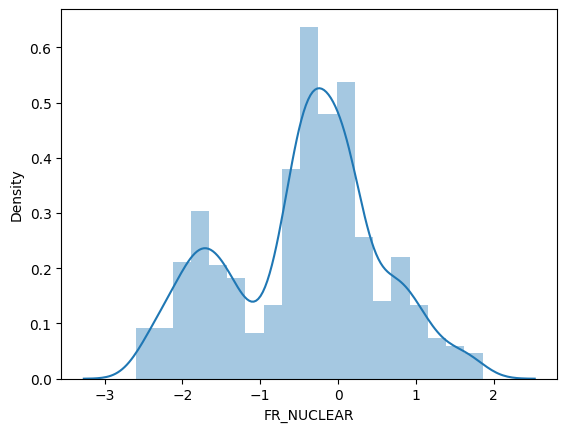

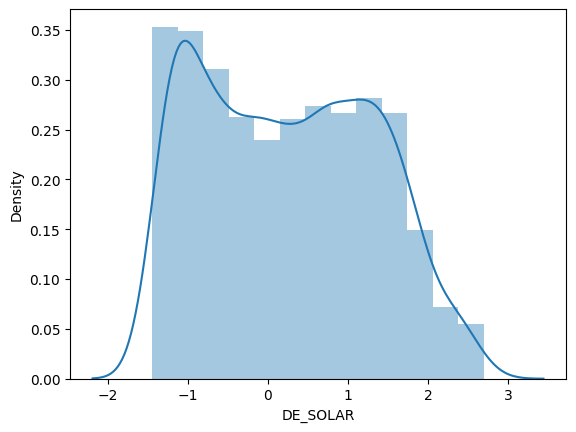

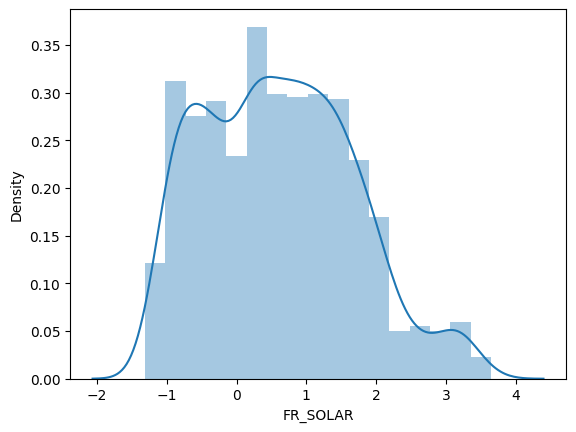

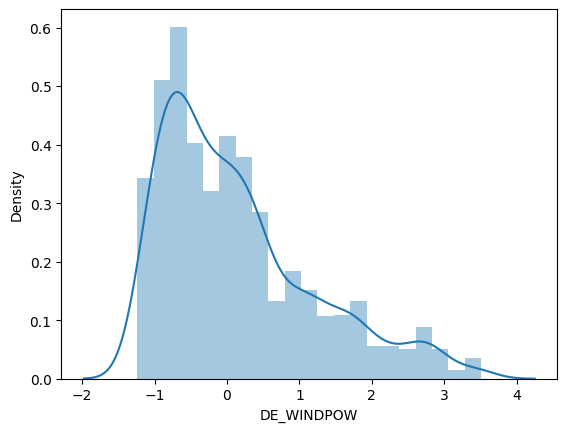

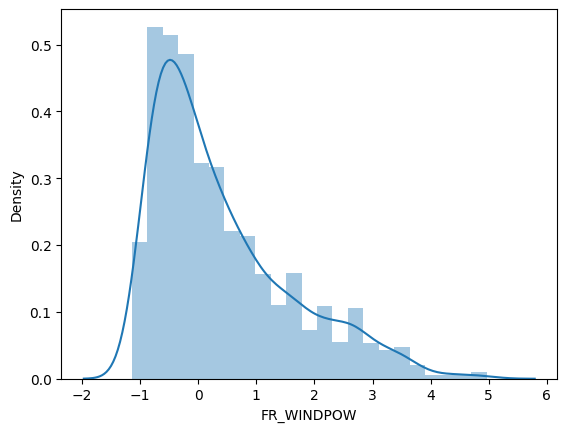

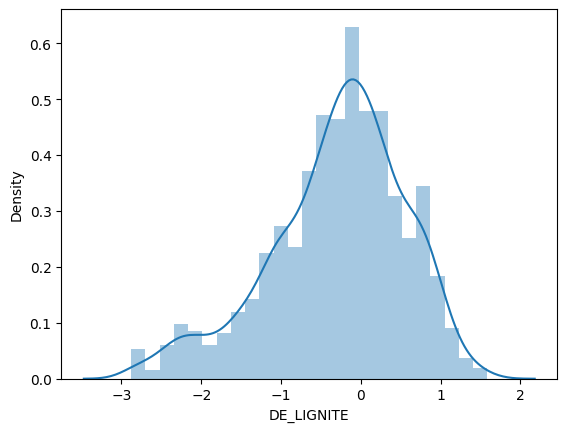

<Figure size 640x480 with 0 Axes>

In [49]:
### add code here - fix, make smalller charts
for col in X_train.select_dtypes('float'):
  # print(col)
  plt.figure()
  sns.distplot(X_train[col])

observations here

### Correlation Analysis

We can plot the correlation matrix to see whether any columns are correlated.

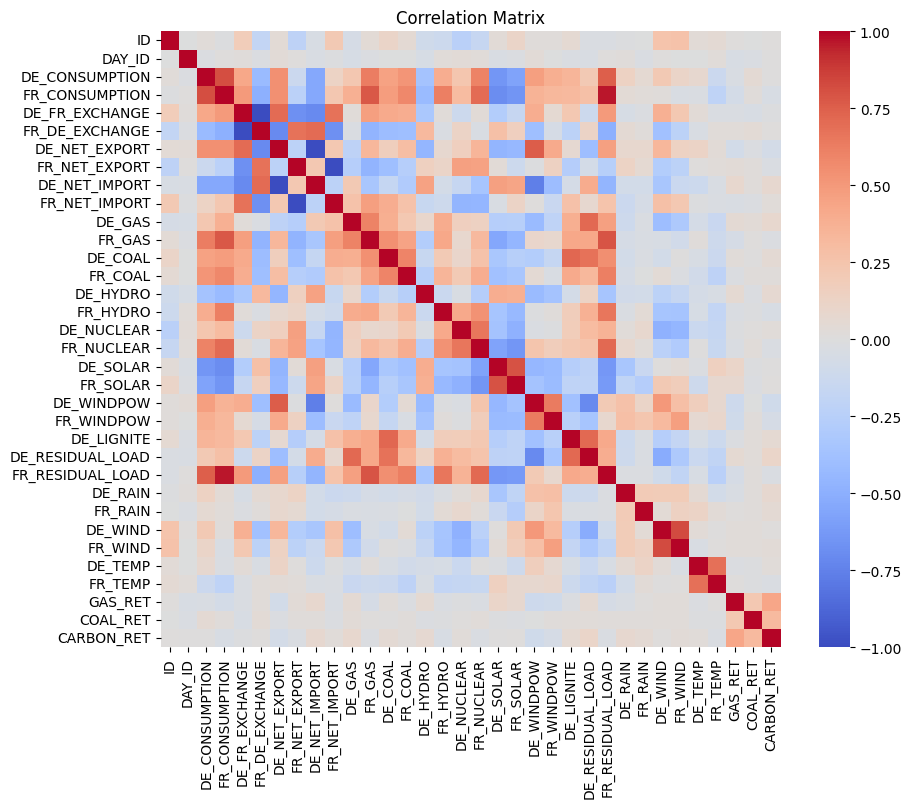

In [21]:
numerical_columns = X_train.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

We consider +/-0.8 to be a high correlation. We filter for these correlations below to see which columns are highly correlated.

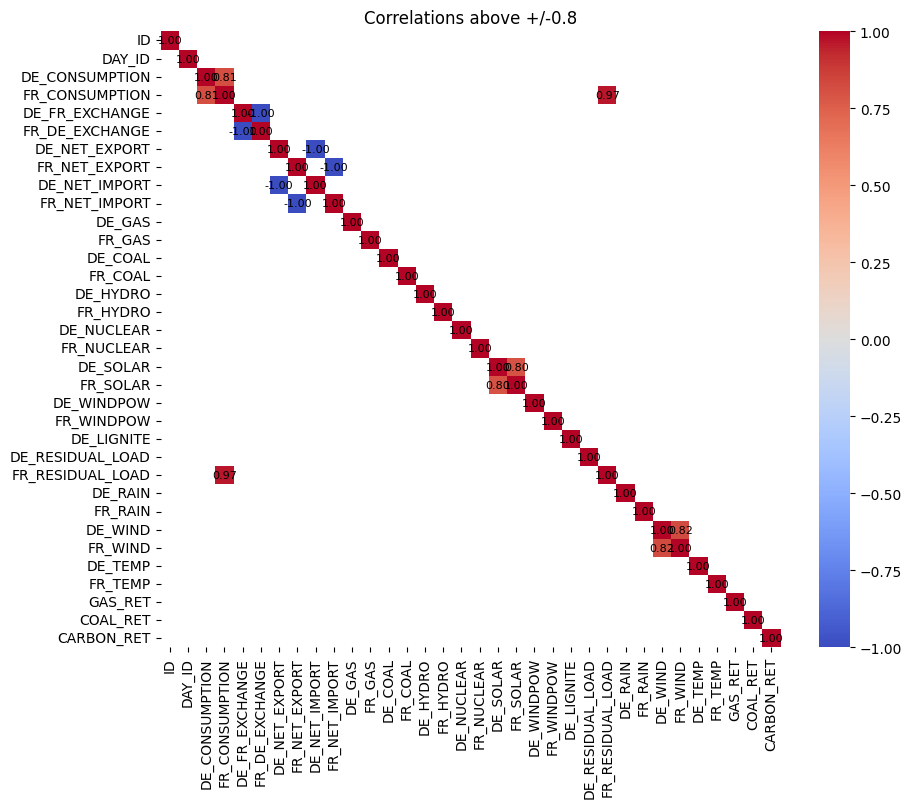

In [31]:
# Filter correlations above 0.8
high_correlations = correlation_matrix[correlation_matrix.abs() > 0.8]

plt.figure(figsize=(10, 8))
annot_kws = {"ha": 'center', "va": 'center', "fontsize": 8, "color": 'black'}
sns.heatmap(high_correlations, annot=True, cmap='coolwarm', fmt=".2f", annot_kws=annot_kws)
plt.title('Correlations above +/-0.8')
plt.show()

From the correlation plot, we observe the following correlations:
- FR_CONSUMPTION and FR_RESIDUAL_LOAD
- FR_CONSUMPTION and DE_CONSUMPTION 
- DE_FR_EXCHANGE and FR_DE_EXCHANGE
- DE_NET_IMPORT and DE_NET_EXPORT
- FR_NET_IMPORT and FR_NET_EXPORT
- DE_SOLAR and FR_SOLAR
- DE_WIND and FR_WIND

It is likely that we will need to remove some of these columns.

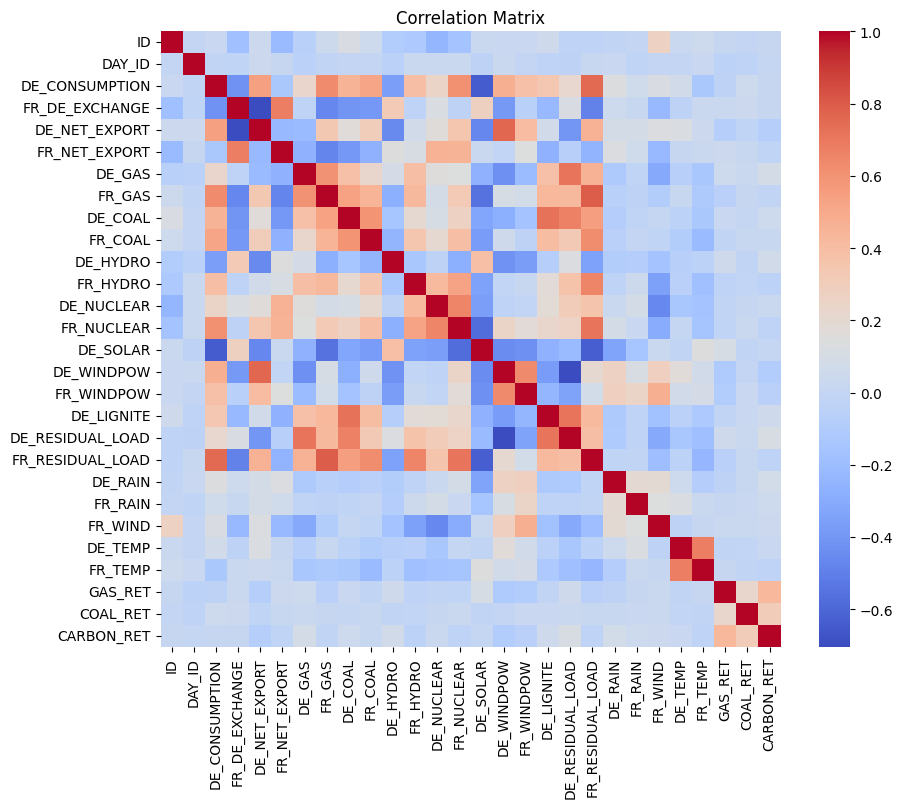

In [39]:
X_train_no_corr = X_train.drop(['COUNTRY', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'FR_SOLAR', 'DE_WIND'], axis=1)
correlation_matrix = X_train_no_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

There are no more correlations above 0.8 as we can see below.

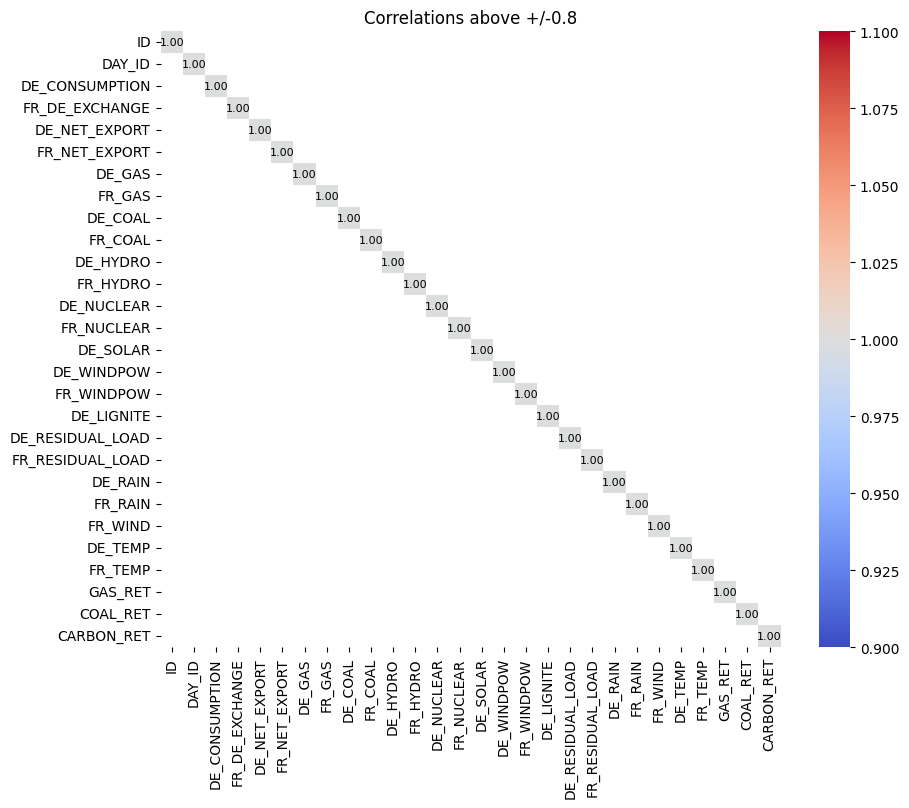

In [41]:
# Filter correlations above 0.8
high_correlations = correlation_matrix[correlation_matrix.abs() > 0.8]

plt.figure(figsize=(10, 8))
annot_kws = {"ha": 'center', "va": 'center', "fontsize": 8, "color": 'black'}
sns.heatmap(high_correlations, annot=True, cmap='coolwarm', fmt=".2f", annot_kws=annot_kws)
plt.title('Correlations above +/-0.8')
plt.show()

### Encoding non-numerical columns

In [ ]:
import pandas as pd

X_train['country_encoded'] = X_train['COUNTRY'].apply(lambda x: 0 if x == 'FR' else 1)

### Missing values

Let's see the percentage of missing values we have for each column.

In [42]:
(X_train.isna().sum() / len(X_train)) * 100

ID                  0.000000
DAY_ID              0.000000
COUNTRY             0.000000
DE_CONSUMPTION      0.000000
FR_CONSUMPTION      0.000000
DE_FR_EXCHANGE      1.673360
FR_DE_EXCHANGE      1.673360
DE_NET_EXPORT       8.299866
FR_NET_EXPORT       4.685408
DE_NET_IMPORT       8.299866
FR_NET_IMPORT       4.685408
DE_GAS              0.000000
FR_GAS              0.000000
DE_COAL             0.000000
FR_COAL             0.000000
DE_HYDRO            0.000000
FR_HYDRO            0.000000
DE_NUCLEAR          0.000000
FR_NUCLEAR          0.000000
DE_SOLAR            0.000000
FR_SOLAR            0.000000
DE_WINDPOW          0.000000
FR_WINDPOW          0.000000
DE_LIGNITE          0.000000
DE_RESIDUAL_LOAD    0.000000
FR_RESIDUAL_LOAD    0.000000
DE_RAIN             6.291834
FR_RAIN             6.291834
DE_WIND             6.291834
FR_WIND             6.291834
DE_TEMP             6.291834
FR_TEMP             6.291834
GAS_RET             0.000000
COAL_RET            0.000000
CARBON_RET    

We can also visualize this.

<Axes: >

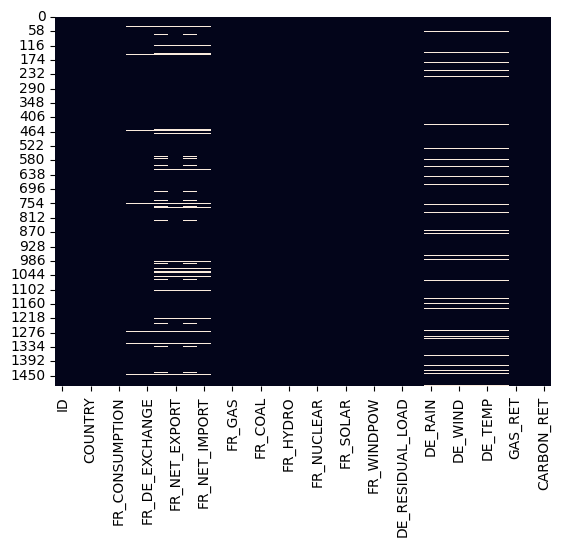

In [10]:
sns.heatmap(X_train.isna(), cbar=False)

We try 3 different methods for missing values and see how this will impact model results. The three methods are:
1. 
2. 
3.

We will remove the rows with missing values. We prefer to do this than to fill with 0.

In [43]:
X_train_cleaned = X_train.dropna()

In [48]:
X_train_cleaned.shape

(1276, 35)

## Model Testing

### Baseline: Linear Regression - gabri

The benchmark for this challenge consists in a simple linear regression, after a light cleaning of the data: The missing (NaN) values are simply filled with 0's and the `COUNTRY` column is dropped - namely we used the same model for France and Germany. 

In [ ]:
lr = LinearRegression()

X_train_clean = X_train.drop(['COUNTRY'], axis=1).fillna(0)
Y_train_clean = Y_train['TARGET']

lr.fit(X_train_clean, Y_train_clean)

output_train = lr.predict(X_train_clean)

def metric_train(output):

    return  spearmanr(output, Y_train_clean).correlation

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train) ))

The Spearman correlation obtained with our model on the train data set is about 27.9%.

NB: Electricity price variations can be quite volatile and this is why we have chosen the Spearman rank correlation as a robust metric for the challenge, instead of the more standard Pearson correlation.

### Model 1: Decision Trees - rhianne

### Model 2: Bagging - alix

### Model 3: Random Forest - rhianne

### Model 4: Boosting - vivian

### Model 5: Gradient Boosted Trees - gabri

### Model 6: AdaBoost - alix

### Model 7: XGBoost - vivian

I dont think we need the code below.

## Generate the output

Next, we process the test set the same way as we did on the train set and predict using our linear model, while saving the predictions to a csv file satisfying the challenge output contraints.


In [17]:
X_test.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,2136,524,FR,0.334263,-0.281509,1.042173,-1.042173,0.716838,-1.282216,-0.716838,...,-0.340008,-0.098752,-0.170879,1.020837,1.100871,0.055794,0.286185,1.485898,-0.267464,1.951327
1,900,728,DE,0.171956,-0.879758,0.912230,-0.912230,0.315475,-1.506543,-0.315475,...,-0.987289,0.789124,1.422063,0.474978,0.827341,1.544394,1.559351,-0.427837,-0.264420,-1.473669
2,375,84,DE,0.195331,-0.427774,-0.535792,0.535792,-0.927339,-0.304559,0.927339,...,-0.416412,-0.539948,-0.430405,-0.967479,-0.655789,0.160769,-0.240024,0.438932,0.163146,-0.454476
3,43,352,DE,0.393072,-0.507126,-1.378073,1.378073,-1.664931,1.349263,1.664931,...,-0.505793,5.623228,-2.046479,-0.537130,-0.781634,0.490128,-1.689460,-1.143164,-0.228964,-0.181086
4,504,24,DE,0.143362,-0.524899,-1.030414,1.030414,-1.005184,0.832404,1.005184,...,-0.635998,NaN,NaN,NaN,NaN,NaN,NaN,0.232096,-0.078845,0.190155


In [18]:
X_test_clean = X_test.drop(['COUNTRY'], axis=1).fillna(0)

Y_test_submission = X_test[['ID']].copy()
Y_test_submission['TARGET'] = lr.predict(X_test_clean)

Y_test_submission.to_csv('benchmark_qrt.csv', index=False)


After submitting this benchmark_qrt.csv file at https://challengedata.ens.fr, we obtain a public score of around 15.9 % - this is the score to beat!


## Tips and ideas for improvements 

- Thinking about the fundamental price drivers of electricity in each country may be useful. 

- The dataset is small, so you will need to be careful not to overfit your models. It will be useful to use good crossvalidation practices. 
